In [1]:
from pathlib import Path
import sys

sys.path.append(str(Path("..").resolve()))

In [2]:
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from wheat.dataset import WheatDataset
from wheat.model import get_train_efficientdet
from effdet.data.loader import DetectionFastCollate, PrefetchLoader

In [3]:
OFFSET = np.asarray([0.485, 0.456, 0.406])[:, np.newaxis, np.newaxis]
SCALE = np.asarray([0.229, 0.224, 0.225])[:, np.newaxis, np.newaxis]

In [6]:
model = get_train_efficientdet("tf_efficientdet_d0", image_size=(512, 512))
model.load_state_dict(torch.load("../wheatdet.pth"))
model.eval()
_ = model.cuda()

In [10]:
df = pd.read_csv("../data/512/train.csv")
bboxes = np.stack(df["bbox"].apply(lambda x: np.fromstring(x[1:-1], sep=",")))
for i, col in enumerate(["x", "y", "w", "h"]):
    df[col] = bboxes[:, i]
df["x2"] = df["x"] + df["w"]
df["y2"] = df["y"] + df["h"]
valid_dataset = WheatDataset(
    df=df, image_dir="../data/512/train/", transforms=None
)
valid_dataloader = PrefetchLoader(DataLoader(
    valid_dataset,
    batch_size=4,
    pin_memory=False,
    shuffle=True,
    collate_fn=DetectionFastCollate(anchor_labeler=None),
    num_workers=2,
))

In [37]:
batch, target = next(iter(valid_dataloader))

In [38]:
with torch.no_grad():
    output = model(batch, target)
detections = output["detections"]
detections[:, :, [1, 0, 3, 2]] = detections[:, :, [0, 1, 2, 3]]

In [39]:
output["loss"], output["class_loss"], output["box_loss"]

(tensor(0.5146, device='cuda:0'),
 tensor(0.2876, device='cuda:0'),
 tensor(0.0045, device='cuda:0'))

In [40]:
df.iloc[2]

image_id                     b6ab77fd7
width                              512
height                             512
bbox        [188.5, 252.0, 37.0, 80.0]
source                         usask_1
x                                188.5
y                                  252
w                                   37
h                                   80
x2                               225.5
y2                                 332
Name: 2, dtype: object

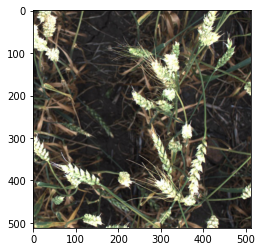

In [41]:
IDX = 0
img = ((batch[IDX].cpu().numpy() * SCALE + OFFSET).transpose(1,2,0) * 255.).astype(np.uint8).copy()
plt.imshow(img)

In [42]:
boxes = detections[IDX, :10].cpu().numpy()
for i in range(8):
    box = boxes[i]
    _ = cv2.rectangle(
      img,
      (box[0], box[1]),
      (box[2], box[3]),
      (0, 255, 0), 3)
    print(", ".join(["%5.1f" % x for x in box[:4]] + ["%.2f" % (box[4] * 100)]))

  0.5, 278.8,  46.6, 354.9, 87.93
268.8, 284.1, 325.7, 381.9, 75.86
 27.1,  83.7,  68.7, 125.7, 75.76
399.8, 476.1, 442.4, 512.0, 74.93
223.5, 182.0, 290.4, 243.2, 74.38
288.5, 463.5, 329.2, 508.6, 73.89
275.7, 112.6, 340.3, 182.2, 73.84
285.6, 207.8, 330.5, 247.1, 72.96


In [43]:
for i in range(8):
    box = target["bbox"][IDX, i, :4] 
    _ = cv2.rectangle(
        img,
        (box[0], box[1]),
        (box[2], box[3]),
        (220, 0, 0), 3)

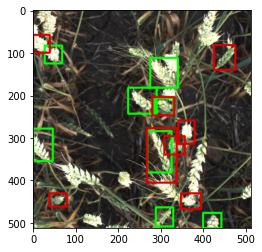

In [44]:
plt.imshow(img)

In [45]:
target["bbox"][IDX, 0, :4]

tensor([280.5000, 204.0000, 331.5000, 247.0000], device='cuda:0')